# Training

- Use this notebook after you've built your dataset to train the model.
- Training will create a model directory with:
    - `model_0000XXX.pth`: weights that are regularly saved during training
    - `config.yaml`: the model configuration used during the last training performed.
    - `training.log`: a log file that contains all the logs displayed in the notebook during training (useful if you close your notebook during a long training session).

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=0


## Check Dataset

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


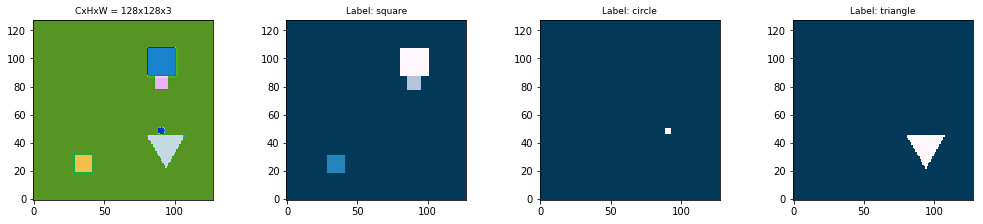

In [2]:
config['SOLVER']['IMS_PER_BATCH'] = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(1)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=14, limit=3, cmap="PuBu_r")

## Training

In [5]:
# Use the last model in the model dir
# If False, create a new model from scratch.
# If `model_to_use` is set, we use this one instead.
use_last_model = True
model_to_use = None

# Configure the training
config['DATA_DIR'] = str(data_dir)

config['MODEL']['DEVICE'] = "cuda"

config['DATALOADER']['NUM_WORKERS'] = 16
config['SOLVER']['IMS_PER_BATCH'] = 4

# config['SOLVER']['MAX_ITER'] = 300
# config['SOLVER']['BASE_LR'] = 0.005
# config['SOLVER']['STEPS'] = [120, 200]
# config['SOLVER']['CHECKPOINT_PERIOD'] = 100

config['SOLVER']

CfgNode({'MAX_ITER': 300, 'BASE_LR': 0.005, 'BIAS_LR_FACTOR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 0.0001, 'WEIGHT_DECAY_BIAS': 0, 'GAMMA': 0.1, 'STEPS': [120, 200], 'WARMUP_FACTOR': 0.33, 'WARMUP_ITERS': 500, 'WARMUP_METHOD': 'linear', 'CHECKPOINT_PERIOD': 100, 'IMS_PER_BATCH': 4})

In [6]:
# Setup training
training_args, current_model_path = maskflow.training.build_model(config,
                                                                  model_dir,
                                                                  use_last_model=use_last_model,
                                                                  model_to_use=model_to_use,
                                                                  use_pretrained_weights=True)

2018-11-04 11:20:22,084:INFO:root: Training model directory set: /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.04-11:20:22
2018-11-04 11:20:22,085:INFO:root: Building the model...
2018-11-04 11:20:22,637:INFO:root: Use pretrained weights from https://download.pytorch.org/models/maskrcnn/e2e_mask_rcnn_R_50_FPN_1x.pth
2018-11-04 11:20:22,928:INFO:maskrcnn_benchmark.utils.checkpoint: No checkpoint found. Initializing model from scratch
2018-11-04 11:20:22,928:INFO:root: Create the data loader.
2018-11-04 11:20:22,929:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
# Train
from maskrcnn_benchmark.engine.trainer import do_train

logging.info(f"Start training at iteration {training_args['arguments']['iteration']}")
do_train(**training_args)

2018-11-04 11:20:23,753:INFO:root: Start training at iteration 0
2018-11-04 11:20:23,754:INFO:maskrcnn_benchmark.trainer: Start training
2018-11-04 11:20:24,727:INFO:maskrcnn_benchmark.trainer: eta: 0:04:51  iter: 0  loss: 5.9222 (5.9222)  loss_classifier: 1.2669 (1.2669)  loss_box_reg: 0.0234 (0.0234)  loss_mask: 3.6388 (3.6388)  loss_objectness: 0.6121 (0.6121)  loss_rpn_box_reg: 0.3810 (0.3810)  time: 0.9704 (0.9704)  data: 0.5883 (0.5883)  lr: 0.001650  max mem: 714
2018-11-04 11:20:33,886:INFO:maskrcnn_benchmark.trainer: eta: 0:02:15  iter: 20  loss: 0.6833 (1.1628)  loss_classifier: 0.1296 (0.2126)  loss_box_reg: 0.0488 (0.0557)  loss_mask: 0.2306 (0.5138)  loss_objectness: 0.0752 (0.1275)  loss_rpn_box_reg: 0.1663 (0.2534)  time: 0.4514 (0.4824)  data: 0.0003 (0.0367)  lr: 0.001784  max mem: 1435
2018-11-04 11:20:43,825:INFO:maskrcnn_benchmark.trainer: eta: 0:02:07  iter: 40  loss: 0.5527 (0.8608)  loss_classifier: 0.1135 (0.1661)  loss_box_reg: 0.0902 (0.0741)  loss_mask: 0.153